<a href="https://colab.research.google.com/github/kulc7878/colab/blob/master/(4W_Total)_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/

!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
 10m_sample.ipynb
'(3W) tag_data_anomaly_detection.ipynb'
'(3W) tag_data_anomaly_detection.ipynb의 사본-1'
'(3W) tag_data_anomaly_detection.ipynb의 사본-2'
'(3W) yahoo_sub5.ipynb'
'(4W-2) AutoEncoder.ipynb'
'(4W-3) AutoEncoder.ipynb'
'(4W) AutoEncoder.ipynb'
'(4W-Total) AutoEncoder.ipynb'
 DBScan.ipynb
 Def_DataRefine_All.ipynb
 Def_DataRefine.ipynb
 데이터전처리.ipynb
 LSTM-AutoEncoding.ipynb
 LSTM.ipynb
 Sample_DataRefine.ipynb
 test_AD.ipynb
 test-Interpolation.ipynb
'timeseries_anomaly_detection - Keras.io'


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Abnormal"]

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Loading Data, Refine

In [ ]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/drive/MyDrive/colab_data/http_csv.csv")

data = df.drop(['time_stamp'], axis=1)

data['value_1'] = StandardScaler().fit_transform(data['value_1'].values.reshape(-1, 1))
data['value_2'] = StandardScaler().fit_transform(data['value_2'].values.reshape(-1, 1))
data['value_3'] = StandardScaler().fit_transform(data['value_3'].values.reshape(-1, 1))

data

,value_1,value_2,value_3,abnomal
0,-0.073165,-0.428904,2.450210,0
1,-0.073165,-1.079216,0.705273,0
2,-0.073165,-0.214764,-0.285503,0
3,-0.073165,-0.244161,0.096888,0
4,-0.073165,-0.185738,-0.989240,0
...,...,...,...,...
567493,-0.073165,-0.461192,0.186982,0
567494,-0.073165,-0.386548,-1.537584,0
567495,-0.073165,-0.397064,0.533238,0
567496,-0.073165,-0.386548,-0.281802,0


In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
# nomal 데이터만
X_train = X_train[X_train.abnomal == 0]
# abnomal col 삭제
X_train = X_train.drop(['abnomal'], axis=1)

#y_test abnomal 0,1 값 셋팅
y_test = X_test['abnomal']
# abnomal col 삭제
X_test = X_test.drop(['abnomal'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_test_col2 = np.delete(X_test, 0, axis=1)
# ==============================================================================

X_train_substr = data[0:300000]
X_test_substr = data[300000:-1]
y_test_substr = X_test_substr['abnomal']
# abnomal col 삭제
X_train_substr = X_train_substr.drop(['abnomal'], axis=1)
X_test_substr = X_test_substr.drop(['abnomal'], axis=1)

print(X_train.shape, X_test.shape, y_test.shape)
print(X_train_substr.shape, X_test_substr.shape, y_test_substr.shape)

(452232, 3) (113500, 3) (113500,)
(300000, 3) (267497, 3) (267497,)


# Loading Model

In [ ]:
# loadModel = load_model('/content/drive/MyDrive/colab_data/model-4w-0.01.h5')
# loadModel = load_model('/content/drive/MyDrive/colab_data/model-4w-0.001.h5')
loadModel = load_model('/content/drive/MyDrive/colab_data/model-4w-0.0001.h5')
# loadModel = load_model('/content/drive/MyDrive/colab_data/model-4w-train300h.h5')

In [ ]:
print(loadModel.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 14)                56        
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 24        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# predictions = loadModel.predict(X_test_col2)    # model-4w-0.01.h5,   model-4w-0.001.h5
# mse = np.mean(np.power(X_test_col2 - predictions, 2), axis=1)
# error_df = pd.DataFrame({'reconstruction_error': mse,
#                         'true_class': y_test})

predictions = loadModel.predict(X_test)         # model-4w-0.0001.h5
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

# predictions = loadModel.predict(X_test_substr)    # model-4w-train300h.h5
# mse = np.mean(np.power(X_test_substr - predictions, 2), axis=1)
# error_df = pd.DataFrame({'reconstruction_error': mse,
#                         'true_class': y_test_substr})   # model-4w-train300h.h5

error_df.describe()

,reconstruction_error,true_class
count,113500.000000,113500.000000
mean,0.278754,0.003921
std,3.133909,0.062493
min,0.001784,0.000000
25%,0.005181,0.000000
50%,0.072059,0.000000
75%,0.299618,0.000000
max,127.393478,1.000000


## Precision vs Recall

재현율 높다, 정밀도 낮다 => 찾은 데이터의 수가 많지만 그 중 실제 찾으려는 대상의 비율은 낮다

재현율 낮다, 정밀도 높다 => 찾은 데이터의 수는 작지만 그 중 실제 찾으려는 대상의 비율은 높다

이상적으로는, 정밀도와 재현율이 모두 높은 것 좋다.
이는 찾은 데이터 수가 많으며 그 중 실제 찾으려는 대상의 비율이 높다는 것을 의미합니다.

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [ ]:
# error_df.isnull().values.any()
error_df[error_df.isnull()]

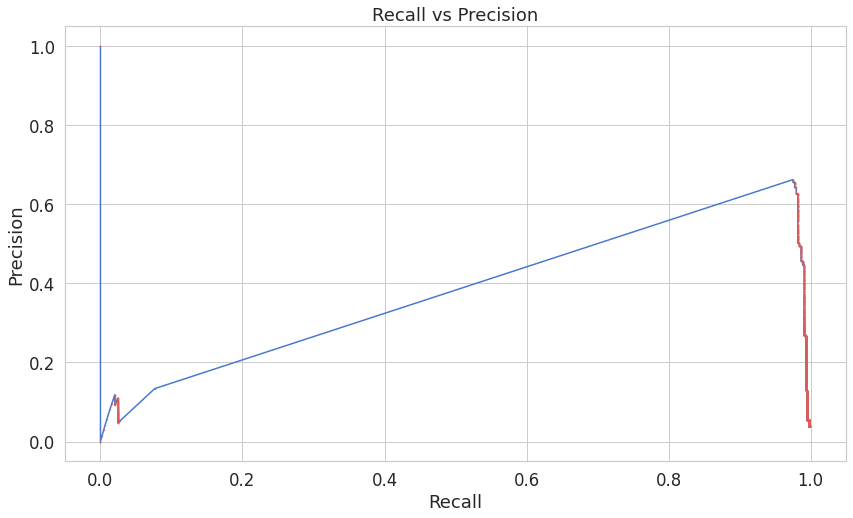

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.plot(recall, precision, 'ro', marker='.', ms=1)
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


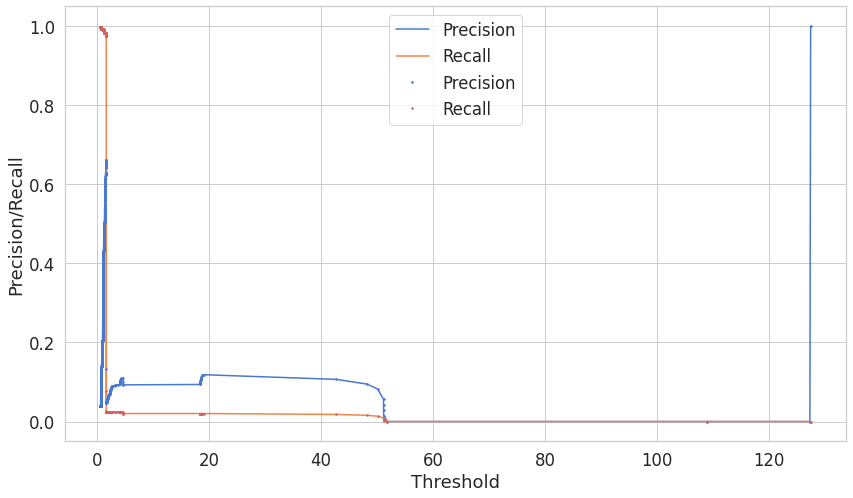

In [ ]:
plt.figure()
plt.plot(th, precision[1:], label='Precision')
plt.plot(th, recall[1:], label='Recall')
# plt.plot(th, precision[1:],'bo', label='Precision', marker='.', markersize=3)
# plt.plot(th, recall[1:],'ro', label='Recall', marker='.', markersize=3)

plt.xlabel('Threshold');
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Prediction

In [ ]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision, recall)) if p==r][0]
print('index_cnt: ', index_cnt, ', precision: ',precision[index_cnt],', recall: ',recall[index_cnt], )

# fixed Threshold
threshold = th[index_cnt]
print('threshold: ',threshold)

index_cnt:  6010 , precision:  0.0 , recall:  0.0
threshold:  108.83548409097129


And see how well we're dividing the two types of transactions:

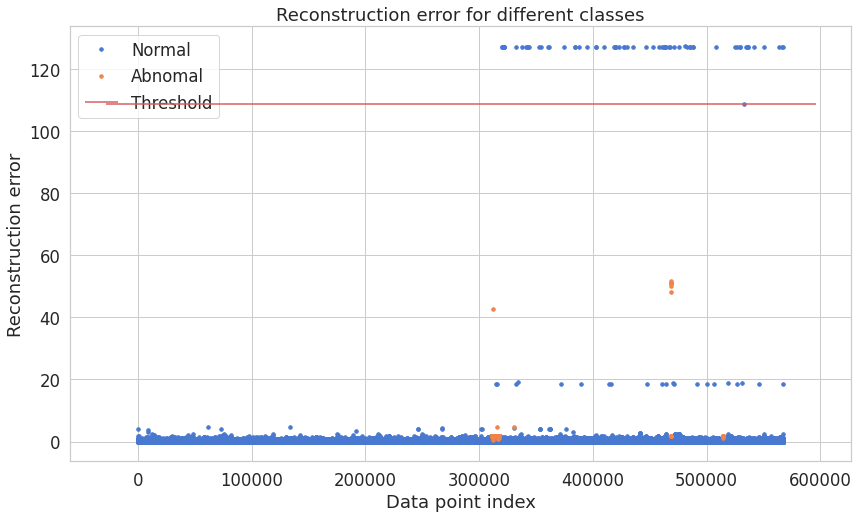

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnomal" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

1~ 10만 : 없음<br/>
11만 ~20만 : 없음<br/>
21만 ~30만 : 1건<br/>
31만 ~ 40만 : 2006건<br/>
41만 ~ 50만 : 103건<br/>
51만 ~ : 101건

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

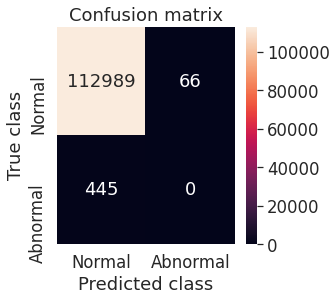

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
# TP = np.int32(conf_matrix[0,0])
tp = conf_matrix[0,0]
fp = conf_matrix[0,1]
fn = conf_matrix[1,0]
tn = conf_matrix[1,1]

total = conf_matrix.sum()
tot_precision = conf_matrix.sum(axis=1)[0]
tot_recall = conf_matrix.sum(axis=0)[0]

print("Accuracy : ", round((tp + tn) / total, 4))
print("Precision : ", round(tp / tot_precision, 4))
print("Recall : ", round(tp / tot_recall, 4))

Accuracy :  0.9955
Precision :  0.9994
Recall :  0.9961


In [ ]:
f_pre, f_re, fbeta_score, support = precision_recall_fscore_support(error_df.true_class, y_pred, average='micro')

print("precision :", round((f_pre), 4))
print("recall :", round((f_re), 4))
print("F1 score on Test :", round((fbeta_score), 4))

precision : 0.9955
recall : 0.9955
F1 score on Test : 0.9955


In [ ]:
len(error_df.reconstruction_error.values)

113500

threshold = 108.83548409097129 를 바꿔보자

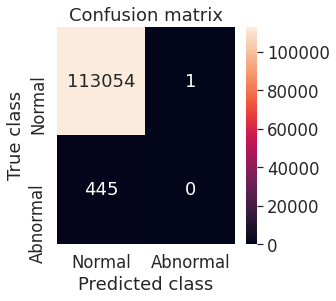

In [ ]:
# low_threshold = 0.299618  #75%
low_threshold = 127.393478  #MAX
y_pred2 = [1 if e > low_threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix2 = confusion_matrix(error_df.true_class, y_pred2)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix2, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
tp = conf_matrix2[0,0]
fp = conf_matrix2[0,1]
fn = conf_matrix2[1,0]
tn = conf_matrix2[1,1]

total = conf_matrix2.sum()
tot_precision = conf_matrix2.sum(axis=1)[0]
tot_recall = conf_matrix2.sum(axis=0)[0]

print("Accuracy : ", round((tp + tn) / total, 4))
print("Precision : ", round(tp / tot_precision, 4))
print("Recall : ", round(tp / tot_recall, 4))

f_pre2, f_re2, fbeta_score2, support2 = precision_recall_fscore_support(error_df.true_class, y_pred2, average='micro')

print('*'* 30, 'F1 Score')
print("precision :", round((f_pre2), 4))
print("recall :", round((f_re2), 4))
print("F1 score on Test :", round((fbeta_score2), 4))

Accuracy :  0.754
Precision :  0.753
Recall :  1.0
****************************** F1 Score
precision : 0.754
recall : 0.754
F1 score on Test : 0.754


In [ ]:
y_pred_1 = np.array(y_pred)
x_test_1 = error_df.true_class.to_numpy()

# conf_matrix = confusion_matrix(error_df.true_class, y_pred)
f_pre1, f_re1, fbeta_score1, support1 = precision_recall_fscore_support(x_test_1, y_pred_1, average='micro')

print("precision :", round((f_pre1), 4))
print("recall :", round((f_re1), 4))
print("F1 score on Test :", round((fbeta_score1), 4))